# Učitavanje potrebnih biblioteka i podataka

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import plotly.express as px
import plotly.io as pio
import folium
from folium.plugins import FastMarkerCluster
pio.renderers.default = 'svg'

In [2]:
df = pd.read_csv('info.csv')

# Statistički pregled stanova u Hrvatskoj

## 1. Izračunavanje medijana cijene po kvadratnom metru u svakoj županiji

### 1. 1. Trakasti dijagram
Stvoren je novi stupac "Price per sqm" koji predstavlja cijenu po kvadratnom metru dobivenu dijeljenjem cijene stana s 
njegovom površinom. Rezultati su prikazani u obliku trakastog dijagrama, gdje je na osi X prikazan medijan cijene po kvadratnom metru, a na osi Y su nazivi županija. Grafički prikaz omogućuje usporedbu medijan cijene po kvadratnom metru među različitim županijama.

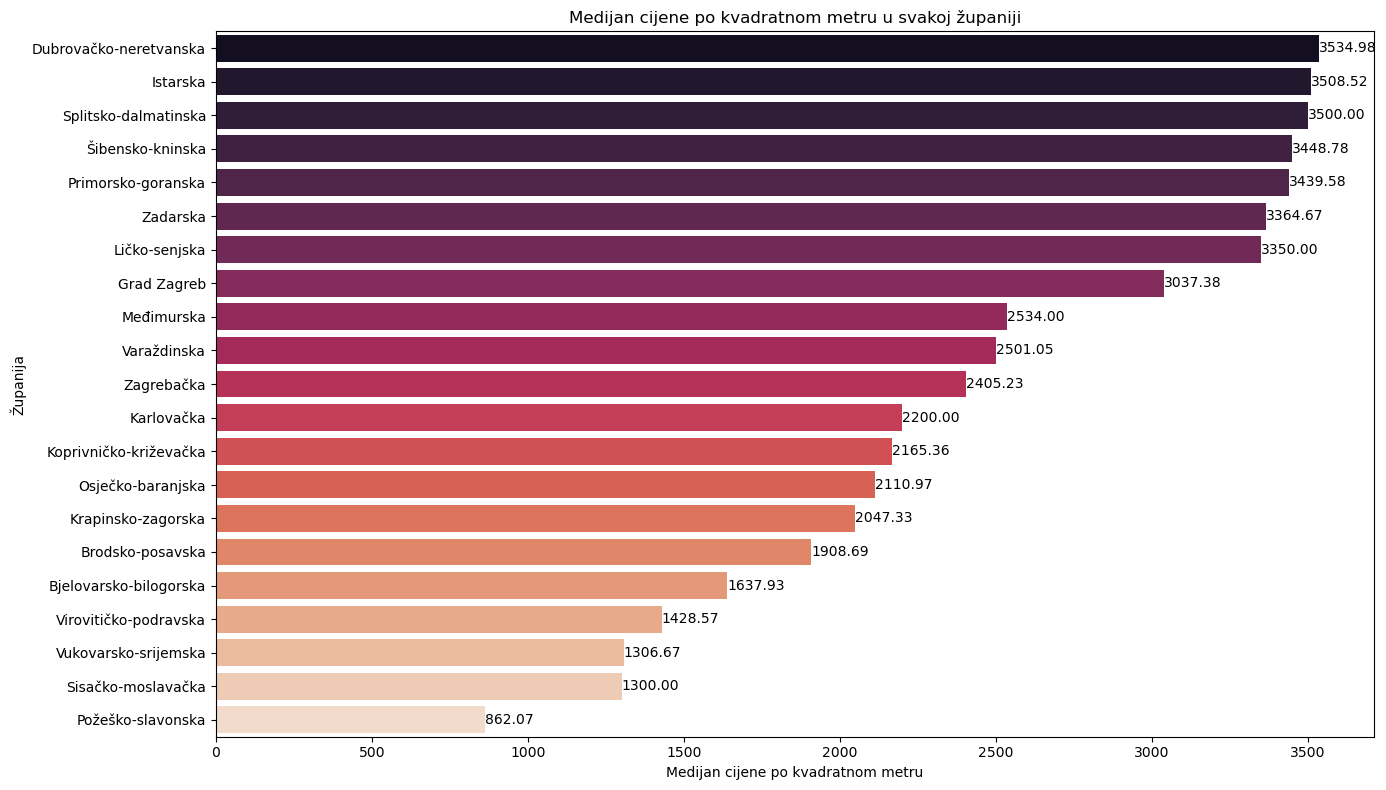

In [3]:
df['Price per sqm'] = df['Price'] / df['Living area']
median_price_per_sqm_county = df.groupby('County')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_county.values, y=median_price_per_sqm_county.index, palette='rocket')
for index, value in enumerate(median_price_per_sqm_county.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Županija')
plt.title('Medijan cijene po kvadratnom metru u svakoj županiji')
plt.tight_layout()
plt.show()

### 1. 2. Heatmap
Isti rezultati su prikazani u obliku heatmapa. Grafički prikaz pruža uvid u regionalne varijacije u cijenama nekretnina.

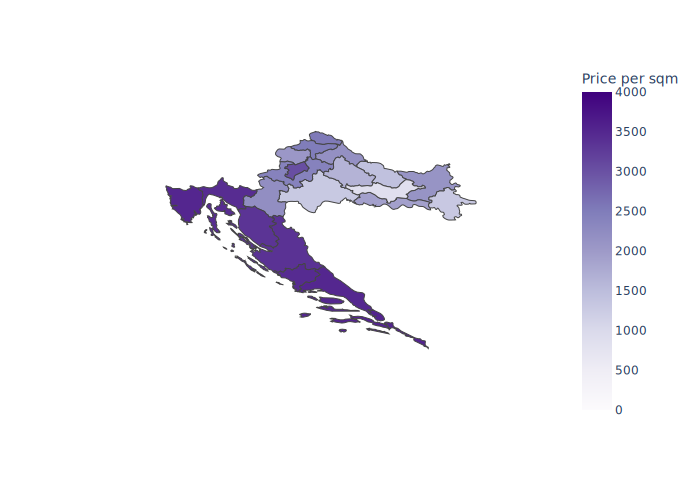

In [4]:
pd.options.mode.chained_assignment = None

croatia_states = json.load(open("hr.geojson", "r", encoding='utf-8'))
state_id_map = {}
for feature in croatia_states["features"]:
    state_id_map[feature["properties"]["name"]] = feature["id"]
df.loc[:, 'Id'] = df['County'].map(state_id_map)

median_price_per_sqm_county = df.groupby('Id')['Price per sqm'].median().reset_index()
fig = px.choropleth(median_price_per_sqm_county, 
                    locations='Id', 
                    geojson=croatia_states, 
                    color='Price per sqm',
                    hover_name='Id',
                    color_continuous_scale="purples",
                    range_color=(0, 4000))
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

pd.options.mode.chained_assignment = 'warn'

## 2. Prikaz oglasa na mapi
Filtrirani su redovi kojima "Latitude" poprima vrijednost "Unknown". Svaki marker ima informacije o linku oglasa i cijeni kvadratnog metra.

In [5]:
data = df[df['Latitude'] != 'Unknown']
map = folium.Map(location=[45, 16], zoom_start=6)
callback = """\
function (row) {
    var icon, marker, color;
    if(row[3] > 4000) color = "red";
    else if(row[3] > 3000) color = "orange";
    else color = "green";
    icon = L.AwesomeMarkers.icon({
        icon: "map-marker", markerColor: color});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    marker.bindPopup("Url: " + row[2] + "<br>Price per sqm: " + row[3]);
    return marker;
};
"""

map.add_child(FastMarkerCluster(data[['Latitude', 'Longitude', 'Url', 'Price per sqm']].values.tolist(), callback=callback))
map.save("map.html")
print("Check map.html to see results!")

Check map.html to see results!


## 3. Izračunavanje medijana cijene po kvadratnom metru u 10 najskupljih gradova

Podatci su grupirani po gradovima koristeći medijan cijenu za sortiranje od najskupljeg do 10. najmanjeg skupog grada. Rezultate su prikazani u obliku trakastog dijagrama, gdje su na osi X prikazane vrijednosti medijana cijene po kvadratnom metru, a na osi Y su nazivi gradova.

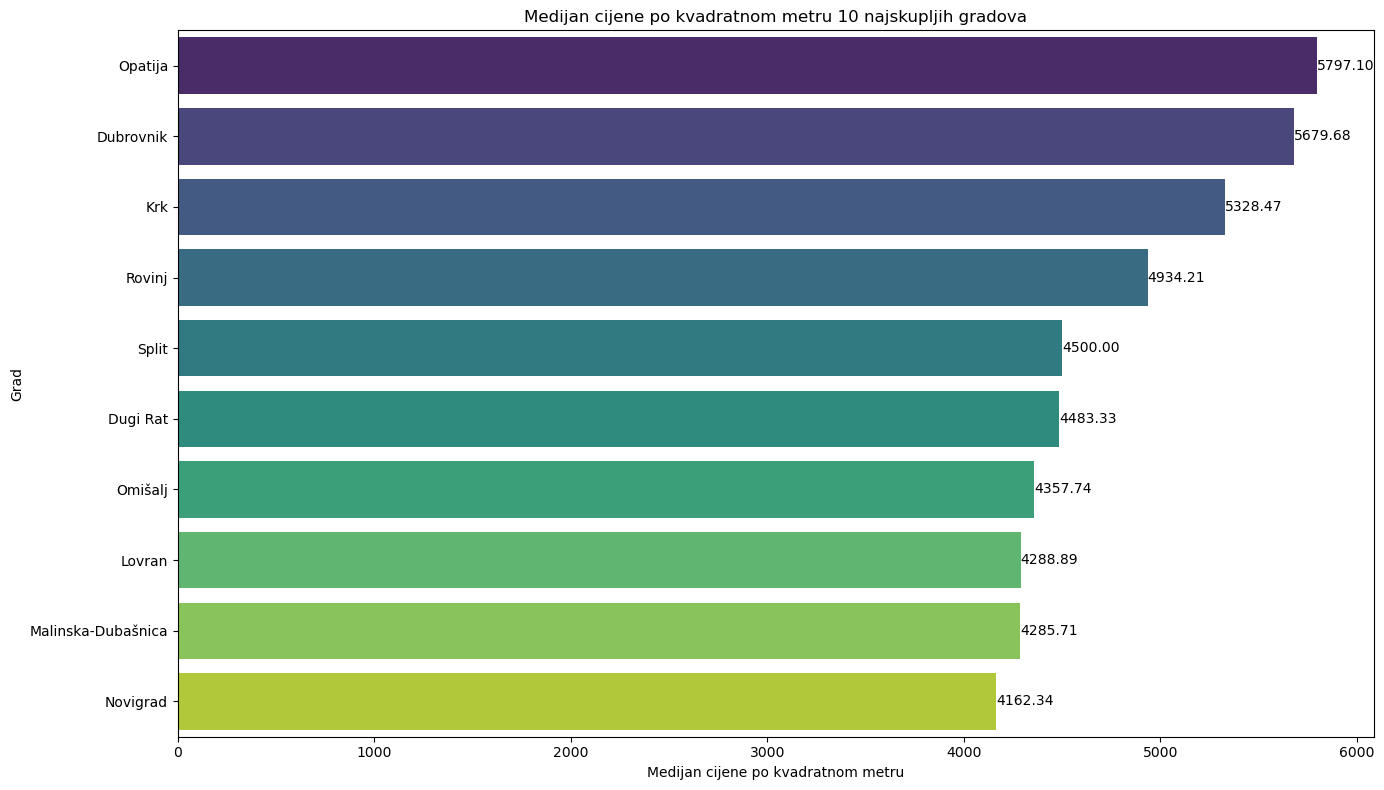

In [6]:
city_counts = df['City'].value_counts()
valid_cities = city_counts[city_counts >= 100].index
df_filtered = df[df['City'].isin(valid_cities)]

median_price_per_sqm_city = df_filtered.groupby('City')['Price per sqm'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru 10 najskupljih gradova')
plt.tight_layout()
plt.show()

## 4. Izračunavanje medijana cijene po kvadratnom metru u 10 najpopularnijih gradova

Prvo je identificirano deset gradova s najvećim brojem stanova na Njuškalu. Zatim su filtrirani podatci kako bi se zadržali samo stanovi koji pripadaju tim gradovima. Rezultati su prikazani koristeći trakasti dijagram koji prikazuje medijan cijene po kvadratnom metru na osi X i nazive gradova na osi Y. Grad Zagreb je županija te nije uvršten među 10 najpopularnijih gradova. Donji Grad i Novi Zagreb-Zapad su unutar Zagreba te su u Njuškalu uvršteni kao gradovi unutar Grada Zagreba.

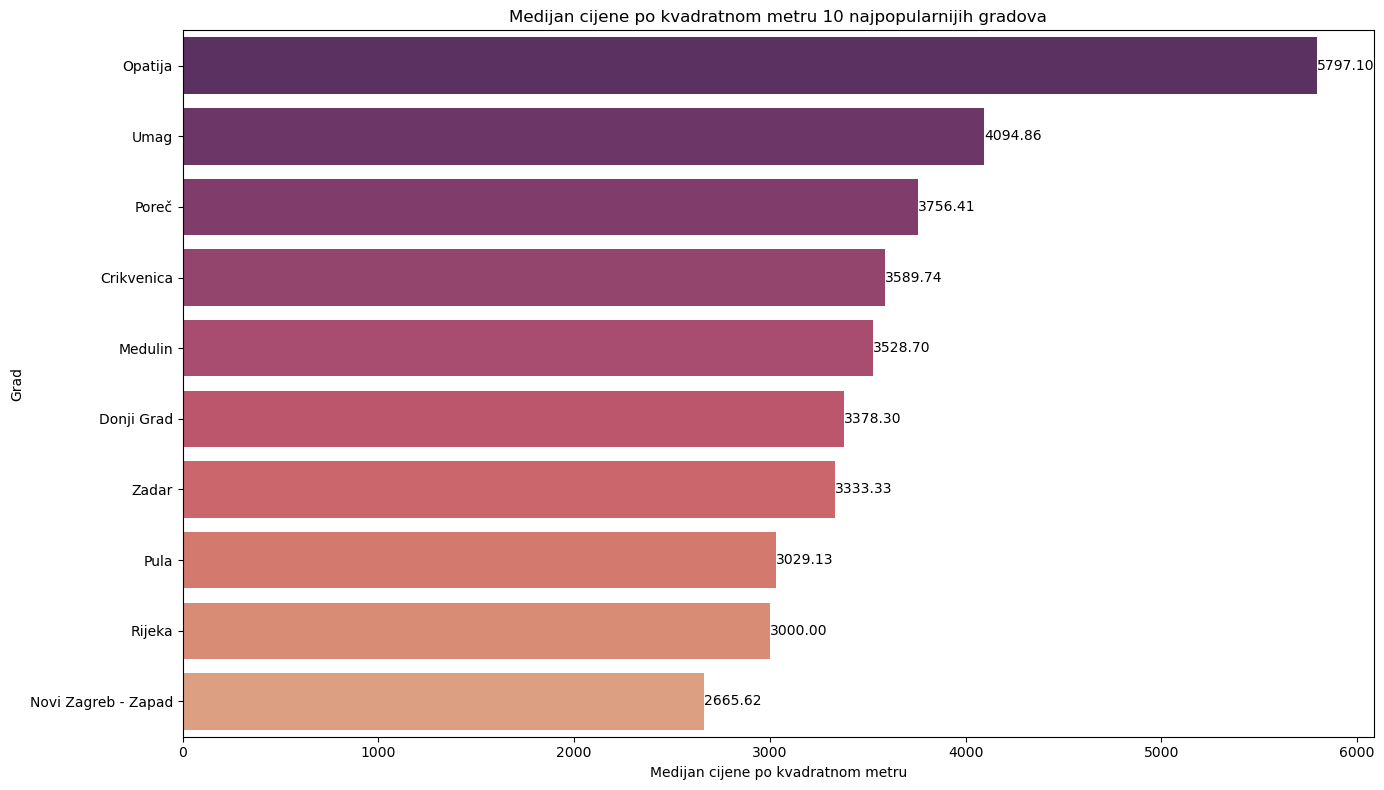

In [7]:
city_counts = df['City'].value_counts().sort_values(ascending=False).head(10)
df_filtered = df[df['City'].isin(city_counts.index)]

median_price_per_sqm_city = df_filtered.groupby('City')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='flare_r')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru 10 najpopularnijih gradova')
plt.tight_layout()
plt.show()

## 5. Broj objavljenih stanova u svibnju

Najprije je pretvoren stupac s datumima u format datuma. S pomoću formatiranog datuma, stvoreni su novi stupci za godinu, mjesec i dan. Zatim su izdvojeni podatci koji se odnose na svibanj 2024. godine. Broj objavljenih stanova za svaki dan u mjesecu prikazani su u obliku grafa stupčastog dijagrama. Na osi X su datumi, dok su na osi Y broj objavljenih oglasa. Graf omogućuje vizualizaciju trendova u objavljivanju stanova tijekom mjeseca i identificiranje dana s najvećim brojem objavljenih oglasa.

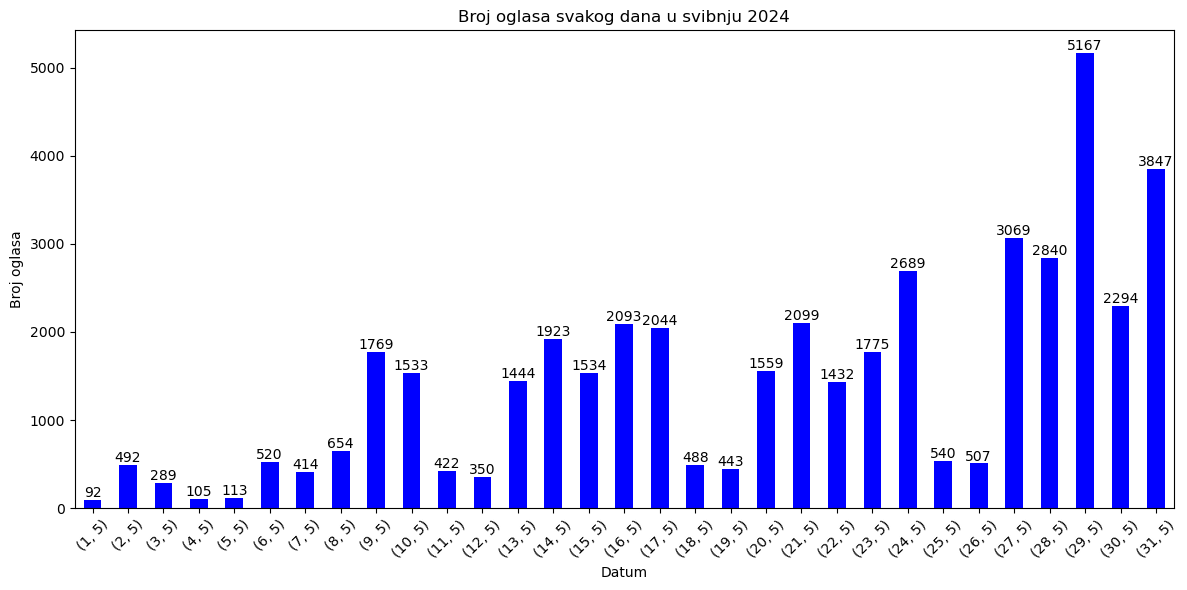

In [8]:
df['Date'] = pd.to_datetime(df['Date'].str.rstrip('.'), format='%d.%m.%Y')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df_april = df[(df['Year'] == 2024) & (df['Month'] == 5)]

listings_per_day = df_april.groupby(['Day', 'Month']).size()

plt.figure(figsize=(12, 6))
ax = listings_per_day.plot(kind='bar', color='b')
plt.xlabel('Datum')
plt.ylabel('Broj oglasa')
plt.title('Broj oglasa svakog dana u svibnju 2024')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## 6. Cijena kvadratnog metra tijekom vremena

Podatci su grupirani prema godini i mjesecu kako bi otkrili trendove u cijenama kroz vrijeme. Rezultati su vizualizirani koristeći linijski dijagram, gdje je na osi X prikazano vrijeme (godina-mjesec), a na osi Y medijan cijene po kvadratnom metru.

Year  Month
2023  8        3144.736842
      10       3172.252747
      11       3182.432432
      12       2922.089552
2024  1        3164.529915
      2        3213.392857
      3        3296.823494
      4        3297.872340
      5        3292.682927
Name: Price per sqm, dtype: float64


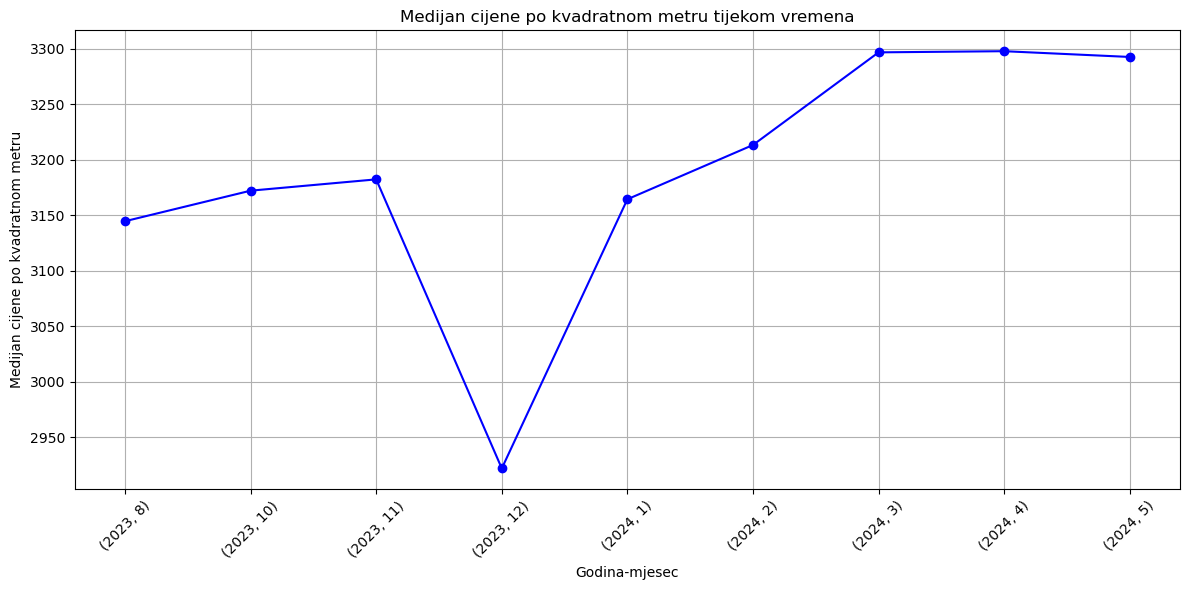

In [9]:
year_month_counts = df.groupby(['Year', 'Month']).size()

valid_year_months = year_month_counts[year_month_counts >= 150].index
df_filtered = df[df[['Year', 'Month']].apply(tuple, axis=1).isin(valid_year_months)]
median_price_per_sqm_year_month = df_filtered.groupby(['Year', 'Month'])['Price per sqm'].median()
print(median_price_per_sqm_year_month)

plt.figure(figsize=(12, 6))
median_price_per_sqm_year_month.plot(marker='o', color='b', linestyle='-')
plt.xlabel('Godina-mjesec')
plt.ylabel('Medijan cijene po kvadratnom metru')
plt.title('Medijan cijene po kvadratnom metru tijekom vremena')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

## 7. Pristutnost stanova po sobama

Odabrani su tri najčešća tipa stana po broja soba. Ostala pojavljivanja grupirana su pod "Ostalo" kako bi se dobila jasnija vizualizaciju. Rezultati su prikazani kružnim dijagramom, gdje su prikazani udjeli svake kategorije u ukupnom broju stanova.

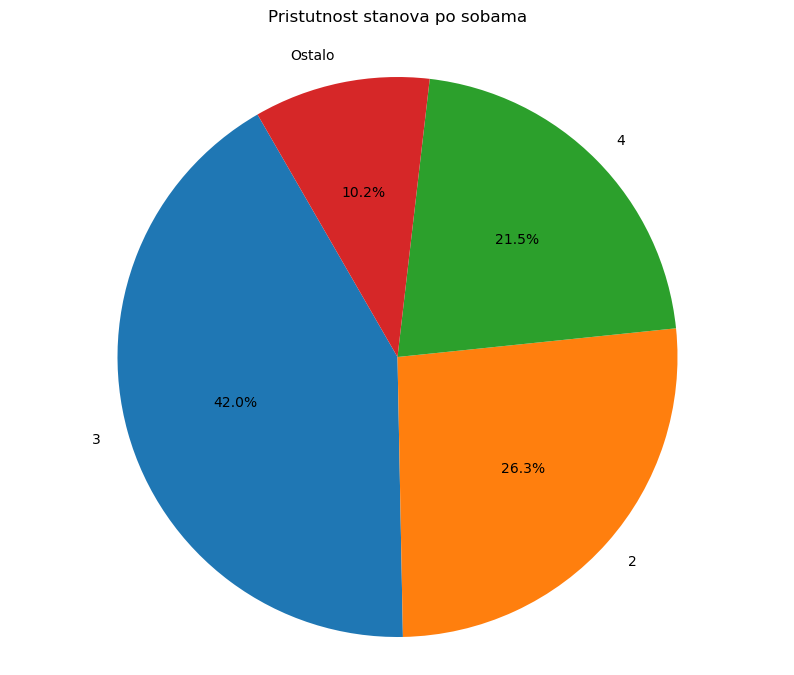

In [10]:
data = df[df['Number of rooms'] != 'Unknown']
number_of_rooms_counts = data['Number of rooms'].value_counts()

top_three = number_of_rooms_counts.head(3)
others_percentage = number_of_rooms_counts[3:].sum()
occurrences = pd.concat([top_three, pd.Series([others_percentage], index=['Ostalo'])])

plt.figure(figsize=(10, 8))
plt.pie(occurrences, labels=occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Pristutnost stanova po sobama', pad=20)
plt.show()

## 8. Energetska učinkovitost

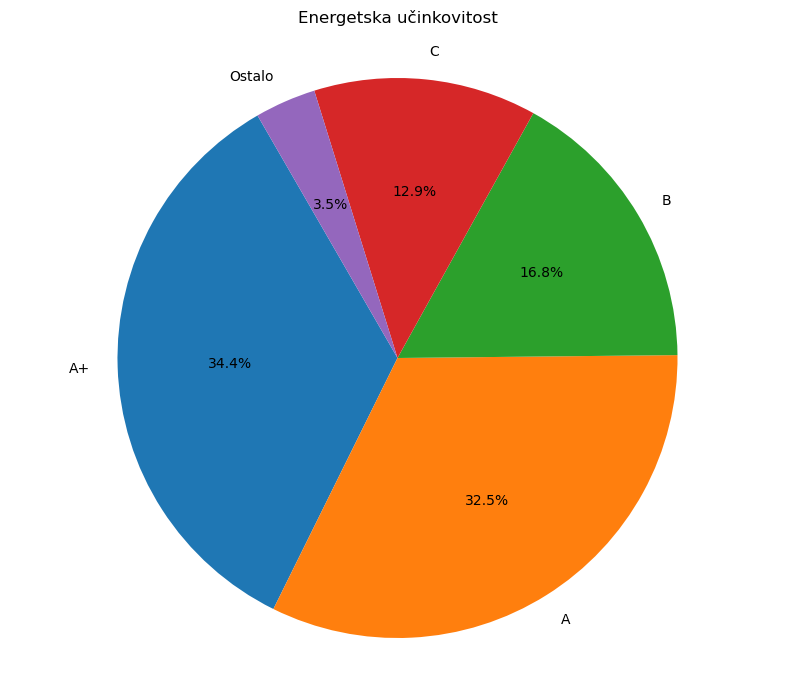

In [11]:
data = df[df['Energy class'] != 'Unknown']
energy_class_counts = data['Energy class'].value_counts()

top_three = energy_class_counts.head(4)
others_percentage = energy_class_counts[4:].sum()
occurrences = pd.concat([top_three, pd.Series([others_percentage], index=['Ostalo'])])

plt.figure(figsize=(10, 8))
plt.pie(occurrences, labels=occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Energetska učinkovitost', pad=20)
plt.show()

## 9. Izračunavanje medijana cijene po kvadratnom metru za svaki kat

Uklanjanje nevažećih ili nepoznatih podataka o katovima. Zatim su identificirani katovi koji se pojavljuju u najmanje 100 oglasa kako bi osigurali relevantnost podataka. Nakon filtriranja, podatke su grupirani po katovima koristeći medijan cijenu za sortiranje od najskupljeg do najmanje skupog kata. Rezultate su vizualizirani pomoću trakastog dijagrama, gdje su na osi X prikazani medijan cijene po kvadratnom metru, a na osi Y su katovi zgrada.

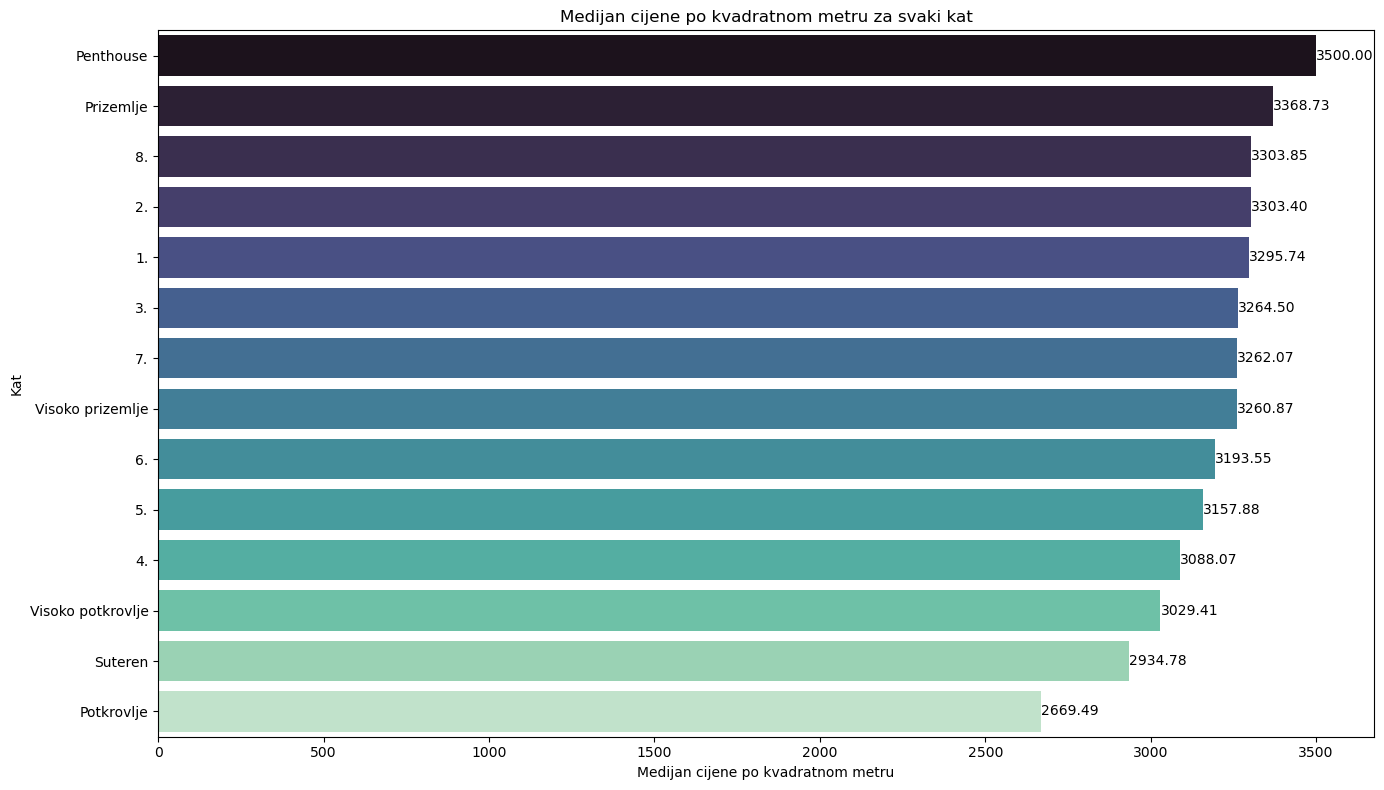

In [12]:
df = df[df['Floor'] != 'Unknown']
floor_counts = df['Floor'].value_counts()

valid_floors = floor_counts[floor_counts >= 100].index
df_filtered = df[df['Floor'].isin(valid_floors)]

median_price_per_sqm_city = df_filtered.groupby('Floor')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='mako')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Kat')
plt.title('Medijan cijene po kvadratnom metru za svaki kat')
plt.tight_layout()
plt.show()

# Statistički pregled stanova u Splitskoj-dalmatinskoj županiji

## 1.Izračunavanje medijana cijene po kvadratnom metru gradova u Splitsko-dalmatinskoj županiji

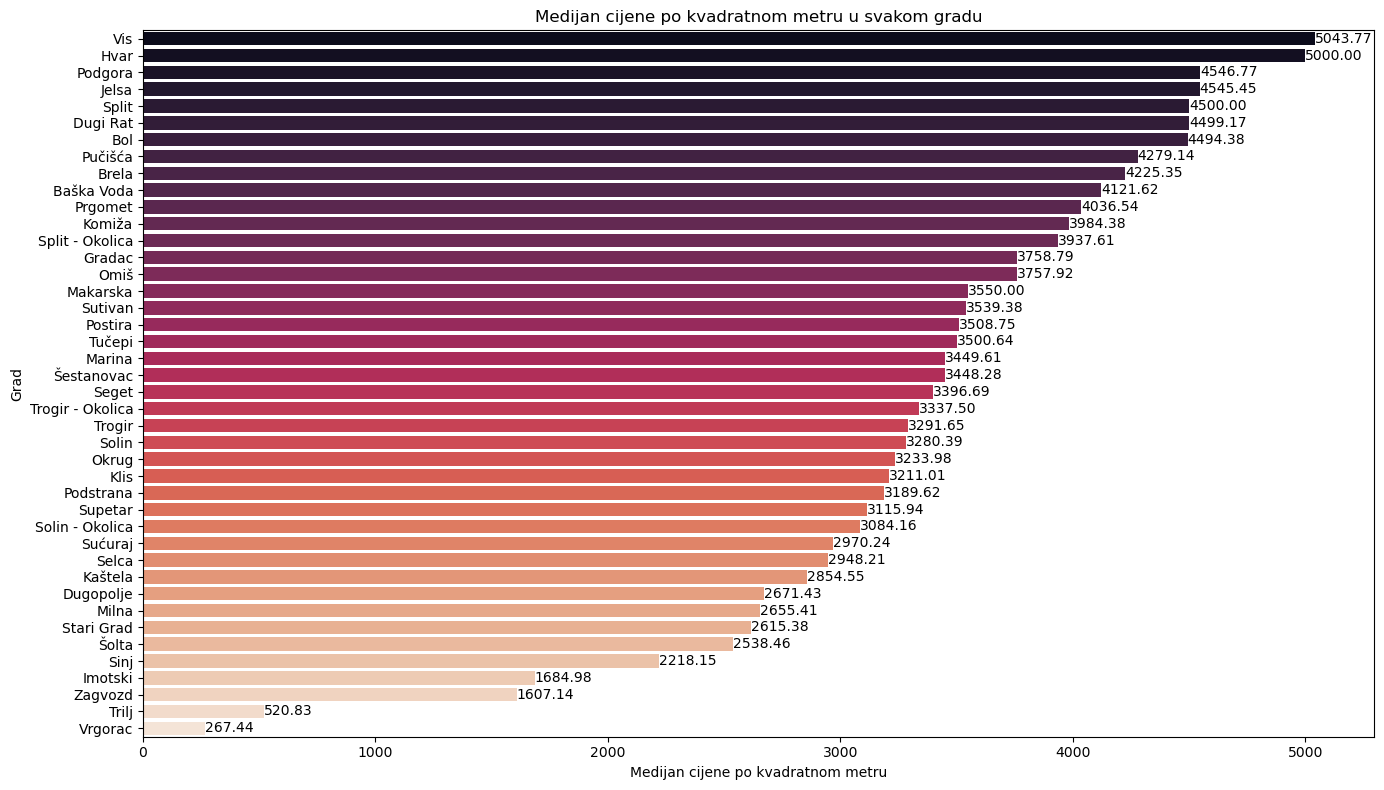

In [13]:
data = df[df['County'] == 'Splitsko-dalmatinska']
median_price_per_sqm_city = data.groupby('City')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='rocket')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru u svakom gradu')
plt.tight_layout()
plt.show()

## 2.Izračunavanje medijana cijene po kvadratnom metru kvartova u gradu Splitu

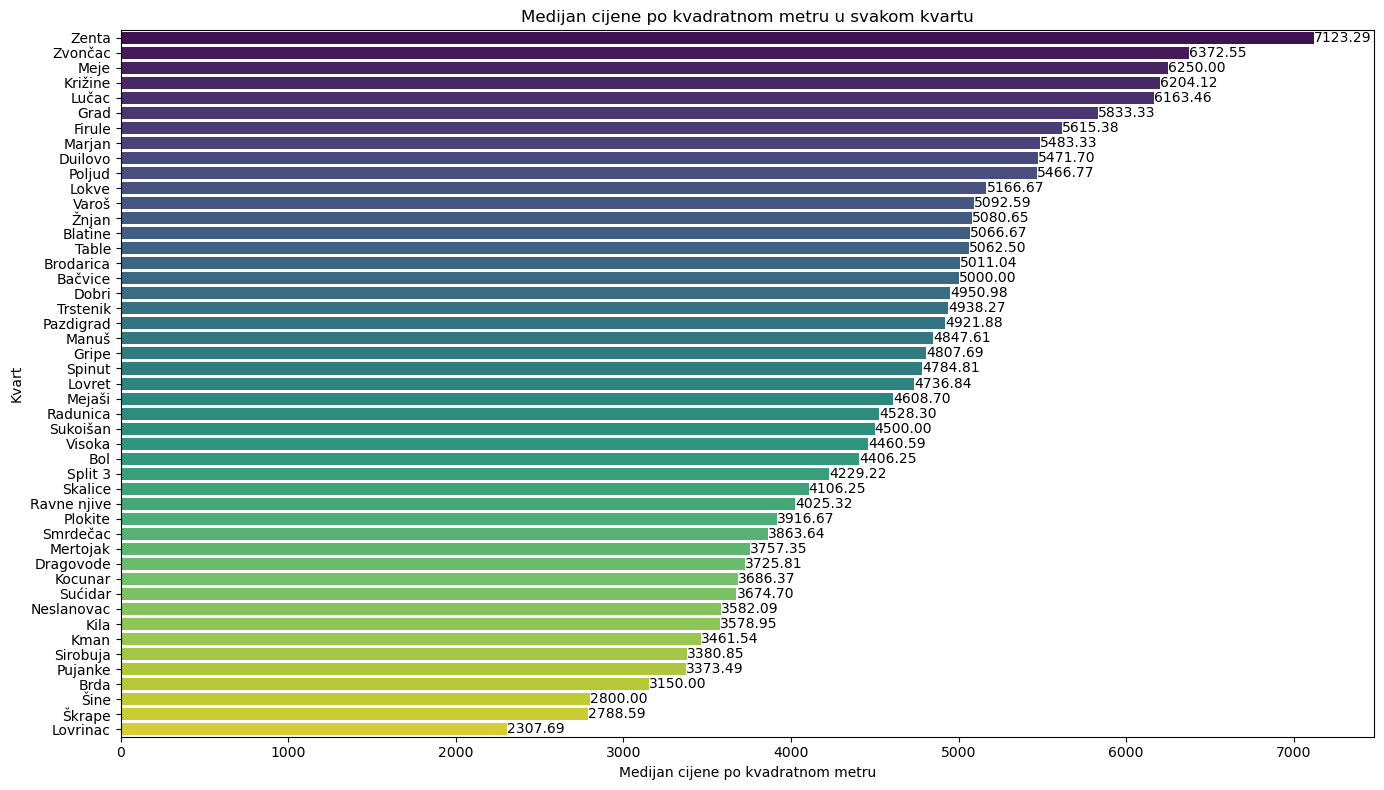

In [14]:
split_data = df[df['City'] == 'Split']
median_price_per_sqm_neighborhood = split_data.groupby('Neighborhood')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_neighborhood.values, y=median_price_per_sqm_neighborhood.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_neighborhood.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Kvart')
plt.title('Medijan cijene po kvadratnom metru u svakom kvartu')
plt.tight_layout()
plt.show()

## 3. Prikaz medijana cijene po kvadratnom metru kvartova u gradu Splitu na mapi

In [15]:
split_data = split_data[split_data['Latitude'] != 'Unknown']
split_data = split_data[split_data['Longitude'] != 'Unknown']
split_data['Latitude'] = split_data['Latitude'].astype(float)
split_data['Longitude'] = split_data['Longitude'].astype(float)

grouped = split_data.groupby('Neighborhood').agg({
    'Latitude': 'median',
    'Longitude': 'median',
    'Price per sqm': 'median'
}).reset_index()

map = folium.Map(location=[43.5081, 16.4402], zoom_start=12)

def get_marker_color(price):
    if price > 4000:
        return "red"
    elif price > 3000:
        return "orange"
    else:
        return "green"

for idx, row in grouped.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Neighborhood: {row['Neighborhood']}<br>Median price per sqm: {row['Price per sqm']}",
        icon=folium.Icon(color=get_marker_color(row['Price per sqm']))
    ).add_to(map)

map.save("neighborhoods_in_split.html")
print("Check neighborhoods_in_split.html to see results!")

Check neighborhoods_in_split.html to see results!


## 4. Traženje povoljnih novogradnji u gradu Splitu i prikaz istih na mapi

Provjeravanje godine izgradnje kako bi se uklonilo nevažeće ili nepotpune podatke. Zatim identifikacija novogradnje (stanove izgrađene u rasponu od 2020. do 2025. godine). Konačno, sortiranje podataka po cijeni po kvadratnom metru te izdvajanje 10 najpovoljnijih stanova.

In [16]:
split_data['Year of construction'] = pd.to_numeric(split_data['Year of construction'], errors='coerce')
split_data = split_data.dropna(subset=['Year of construction'])
split_data = split_data[split_data['Year of construction'].between(2020, 2025)]
split_data['Year of construction'] = split_data['Year of construction'].astype(str)

df_cheapest = split_data.sort_values(by='Price per sqm', ascending=True)
map = folium.Map(location=[43.5081, 16.4402], zoom_start=12)

for index, row in df_cheapest[['Url', 'Price per sqm', 'Latitude', 'Longitude']].head(10).iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Url: {row['Url']}<br>Price per sqm: {row['Price per sqm']}",
    ).add_to(map)

map.save("cheapest_new_apartments_in_split.html")
print("Check cheapest_new_apartments_in_split.html to see results!")

Check cheapest_new_apartments_in_split.html to see results!
